In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [14]:
y = pd.read_csv('/content/Leukemia_data/actual.csv')
print(y.shape)
y.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [16]:
y['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

In [17]:
# Recode label to numeric
y = y.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML'] # for plotting convenience later on

In [18]:
# Import training data
df_train = pd.read_csv('/content/Leukemia_data/data_set_ALL_AML_train.csv')
print(df_train.shape)

# Import testing data
df_test = pd.read_csv('/content/Leukemia_data/data_set_ALL_AML_independent.csv')
print(df_test.shape)

(7129, 78)
(7129, 70)


In [19]:
df_train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,5,call.4,6,call.5,7,call.6,8,call.7,9,call.8,10,call.9,11,call.10,12,call.11,13,call.12,14,call.13,15,call.14,16,call.15,17,call.16,18,call.17,19,call.18,20,call.19,21,call.20,22,call.21,23,call.22,24,call.23,25,call.24,26,call.25,27,call.26,34,call.27,35,call.28,36,call.29,37,call.30,38,call.31,28,call.32,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,-106,A,-138,A,-72,A,-413,A,5,A,-88,A,-165,A,-67,A,-92,A,-113,A,-107,A,-117,A,-476,A,-81,A,-44,A,17,A,-144,A,-247,A,-74,A,-120,A,-81,A,-112,A,-273,A,-20,A,7,A,-213,A,-25,A,-72,A,-4,A,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,-125,A,-85,A,-144,A,-260,A,-127,A,-105,A,-155,A,-93,A,-119,A,-147,A,-72,A,-219,A,-213,A,-150,A,-51,A,-229,A,-199,A,-90,A,-321,A,-263,A,-150,A,-233,A,-327,A,-207,A,-100,A,-252,A,-20,A,-139,A,-116,A,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,-76,A,215,A,238,A,7,A,106,A,42,A,-71,A,84,A,-31,A,-118,A,-126,A,-50,A,-18,A,-119,A,100,A,79,A,-157,A,-168,A,-11,A,-114,A,-85,A,-78,A,-76,A,-50,A,-57,A,136,A,124,A,-1,A,-125,A,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,168,A,71,A,55,A,-2,A,268,A,219,M,82,A,25,A,173,A,243,M,149,A,257,A,301,A,78,A,207,A,218,A,132,A,-24,A,-36,A,255,A,316,A,54,A,81,A,101,A,132,A,318,A,325,A,392,P,241,A,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,-230,A,-272,A,-399,A,-541,A,-210,A,-178,A,-163,A,-179,A,-233,A,-127,A,-205,A,-218,A,-403,A,-152,A,-146,A,-262,A,-151,A,-308,A,-317,A,-342,A,-418,A,-244,A,-439,A,-369,A,-377,A,-209,A,-396,A,-324,A,-191,A,-51,A,-139,A,-367,A,-188,A,-407,A


In [20]:
df_test.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,48,call.4,49,call.5,41,call.6,43,call.7,44,call.8,45,call.9,46,call.10,70,call.11,71,call.12,72,call.13,68,call.14,69,call.15,67,call.16,55,call.17,56,call.18,59,call.19,52,call.20,53,call.21,51,call.22,50,call.23,54,call.24,57,call.25,58,call.26,60,call.27,61,call.28,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,-130,A,-256,A,-62,A,86,A,-146,A,-187,A,-56,A,-55,A,-59,A,-131,A,-154,A,-79,A,-76,A,-34,A,-95,A,-12,A,-21,A,-202,A,-112,A,-118,A,-90,A,-137,A,-157,A,-172,A,-47,A,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,-177,A,-249,A,-23,A,-36,A,-74,A,-187,A,-43,A,-44,A,-114,A,-126,A,-136,A,-118,A,-98,A,-144,A,-118,A,-172,A,-13,A,-274,A,-185,A,-142,A,-87,A,-51,A,-370,A,-122,A,-442,A,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,-28,A,-410,A,-7,A,-141,A,170,A,312,A,43,A,12,A,23,A,-50,A,49,A,-30,A,-153,A,-17,A,59,A,12,A,8,A,59,A,24,A,212,A,102,A,-82,A,-77,A,38,A,-21,A,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,266,A,24,A,142,A,252,A,174,A,142,A,177,A,129,A,146,A,211,A,180,A,68,A,237,A,152,A,270,A,172,A,38,A,309,A,170,A,314,A,319,P,178,A,340,A,31,A,396,A,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,-170,A,-535,A,-233,A,-201,A,-32,A,114,A,-116,A,-108,A,-171,A,-206,A,-257,A,-110,A,-215,A,-174,A,-229,A,-137,A,-128,A,-456,A,-197,A,-401,A,-283,A,-135,A,-438,A,-201,A,-351,A,-256,A,-191,A,-172,A,-496,A,-294,A


In [21]:
# Transform all the call values to numbers (not used in this version)
# df_train.replace(['A','P','M'],['1','2','3'], inplace=True)
# df_test.replace(['A','P','M'],['1','2','3'], inplace=True)

# Remove "call" columns from training and testing data
train_to_keep = [col for col in df_train.columns if "call" not in col]
test_to_keep = [col for col in df_test.columns if "call" not in col]

X_train_tr = df_train[train_to_keep]
X_test_tr = df_test[test_to_keep]

In [22]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', 
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

X_train_tr = X_train_tr.reindex(columns=train_columns_titles)

In [24]:
test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

In [25]:
X_train = X_train_tr.T
X_test = X_test_tr.T

print(X_train.shape) 
X_train.head()

(40, 7129)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7089,7090,7091,7092,7093,7094,7095,7096,7097,7098,7099,7100,7101,7102,7103,7104,7105,7106,7107,7108,7109,7110,7111,7112,7113,7114,7115,7116,7117,7118,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),AFFX-BioB-M_st (endogenous control),AFFX-BioB-3_st (endogenous control),AFFX-BioC-5_st (endogenous control),AFFX-BioC-3_st (endogenous control),AFFX-BioDn-5_st (endogenous control),AFFX-BioDn-3_st (endogenous control),AFFX-CreX-5_st (endogenous control),AFFX-CreX-3_st (endogenous control),hum_alu_at (miscellaneous control),AFFX-DapX-5_at (endogenous control),AFFX-DapX-M_at (endogenous control),AFFX-DapX-3_at (endogenous control),AFFX-LysX-5_at (endogenous control),AFFX-LysX-M_at (endogenous control),AFFX-LysX-3_at (endogenous control),AFFX-PheX-5_at (endogenous control),AFFX-PheX-M_at (endogenous control),AFFX-PheX-3_at (endogenous control),AFFX-ThrX-5_at (endogenous control),AFFX-ThrX-M_at (endogenous control),AFFX-ThrX-3_at (endogenous control),AFFX-TrpnX-5_at (endogenous control),AFFX-TrpnX-M_at (endogenous control),AFFX-TrpnX-3_at (endogenous control),AFFX-HUMISGF3A/M97935_5_at (endogenous control),AFFX-HUMISGF3A/M97935_MA_at (endogenous control),AFFX-HUMISGF3A/M97935_MB_at (endogenous control),AFFX-HUMISGF3A/M97935_3_at (endogenous control),AFFX-HUMRGE/M10098_5_at (endogenous control),AFFX-HUMRGE/M10098_M_at (endogenous control),...,GB DEF = SPR2-1 gene for small proline rich pr...,Metallothionein,GB DEF = Glutamate dehydrogenase,PRSS3 Protease; serine; 3 (trypsin 3),GB DEF = Transmembrane protein Tmp21-IIex,GB DEF = H2B/h gene,ACTB Actin; beta,GAPD Glyceraldehyde-3-phosphate dehydrogenase,CYTOCHROME P450 IA2,Nkat2b mRNA,Natural killer cell receptor (KIR) mRNA,Major Histocompatibility Complex; Class I; C (...,HLA-A MHC class I protein HLA-A (HLA-A28;-B40;...,PRB2 locus salivary proline-rich protein mRNA;...,HLA CLASS II HISTOCOMPATIBILITY ANTIGEN; DQ(W1...,GB DEF = (HLCC85) mRNA for voltage-dependent L...,GB DEF = Endogenous retrovirus clone P1.8 poly...,Integrase gene extracted from Human endogenous...,WUGSC:GS345D13.2 gene (G-protein gamma-1 subun...,TIAL1 TIA1 cytotoxic granule-associated RNA-bi...,Ras-Specific Guanine Nucleotide-Releasing Factor,TYROSINE-PROTEIN KINASE ITK/TSK,(clone p4) 50 kD dystrophin-associated glycopr...,Ifp35 gene extracted from Human BRCA1; Rho7 an...,INHA Inhibin; alpha,S100A9 S100 calcium-binding protein A9 (calgra...,PLGL Plasminogen-like protein,ID1 Inhibitor of DNA binding 1; dominant negat...,ABP1 Amiloride binding protein 1 (amine oxidas...,Transcriptional activator hSNF2b,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-

In [26]:
# Clean up the column names for training and testing data
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for Testing data
X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(38, 7129)
(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,-41,-831,-653,-462,75,381,-118,-565,15091,7,311,-231,21,-107,165,-78,-204,29,-61,-105,-366,-41,-346,-297,-109,-13,215,797,14538,9738,...,391,-763,172,149,341,788,21210,13771,598,396,245,14476,10882,701,2762,-325,-67,346,-68,229,-14,108,28,349,61,273,384,-306,-1827,1582,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,19,-743,-239,-83,182,164,-141,-423,11038,37,134,-161,-21,-180,18,-120,-65,97,15,-49,-330,-41,-772,-259,-192,-219,116,433,615,115,...,200,51,154,418,433,736,21059,15097,563,171,-149,13686,11789,76,1567,-191,-88,290,14,194,56,303,-242,214,-28,143,231,-336,-2380,624,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,19,-1135,-962,-232,208,432,84,-501,16692,183,378,-221,67,-203,238,-124,-161,36,-23,-80,-481,-65,-620,-269,-136,104,476,1474,5669,3272,...,387,-474,180,272,591,959,24292,17378,1808,363,325,6560,5023,804,1090,-258,9,220,-58,294,95,143,-25,464,513,238,720,-204,-1772,753,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,363,-934,-577,-214,142,271,-107,-101,15763,45,268,-27,43,-52,247,-116,-208,22,-10,-74,-240,-33,-560,-261,-366,-148,155,415,4850,2293,...,317,-336,325,149,173,431,17558,13818,576,455,594,8955,9567,367,1708,-357,45,430,-35,128,42,22,-131,342,142,277,307,-320,-2022,743,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,155,-471,-490,-184,32,213,1,-260,18128,-28,118,-153,-8,-111,44,-88,-102,32,5,-18,-228,53,-348,-169,-156,-55,122,483,1284,2731,...,162,-56,279,183,259,605,18530,15619,65,122,126,8443,8512,182,1503,-78,29,159,18,71,42,44,-33,159,71,134,178,-182,-179,626,156,649,57,504,-26,250,314,14,56,-25


In [27]:
# Split into train and test (we first need to reset the index as the indexes of two dataframes need to be the same before you combine them).

# Subset the first 38 patient's cancer types
X_train = X_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subset the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

In [28]:
X_train.describe()

Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,AFFX-BioC-5_st,AFFX-BioC-3_st,AFFX-BioDn-5_st,AFFX-BioDn-3_st,AFFX-CreX-5_st,AFFX-CreX-3_st,hum_alu_at,AFFX-DapX-5_at,AFFX-DapX-M_at,AFFX-DapX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-LysX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-PheX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-ThrX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,AFFX-TrpnX-3_at,AFFX-HUMISGF3A/M97935_5_at,AFFX-HUMISGF3A/M97935_MA_at,AFFX-HUMISGF3A/M97935_MB_at,AFFX-HUMISGF3A/M97935_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,...,X53065_f_at,X64177_f_at,X67491_f_at,X71345_f_at,X97444_f_at,Z80780_f_at,X00351_f_at,X01677_f_at,M31667_f_at,L41268_f_at,X99479_f_at,HG658-HT658_f_at,M94880_f_at,S80905_f_at,X03068_f_at,Z34822_f_at,U87593_f_at,U88902_cds1_f_at,AC002076_cds2_at,D64015_at,HG2510-HT2606_at,L10717_at,L34355_at,L78833_cds4_at,M13981_at,M21064_at,M93143_at,S78825_at,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,...,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,-120.868421,-150.526316,-17.157895,181.394737,-276.552632,-439.210526,-43.578947,-201.184211,99.052632,112.131579,67.947368,-701.105263,-492.868421,-194.394737,110.263158,189.894737,-70.868421,-342.105263,20276.657895,29.210526,170.315789,-95.421053,19.131579,-151.763158,89.631579,-91.631579,-134.157895,-7.368421,-21.184211,-48.447368,-278.342105,7.184211,-550.710526,-245.447368,-206.921053,-2.026316,214.236842,765.263158,4133.368421,2576.315789,...,268.815789,-365.921053,271.210526,483.078947,396.631579,463.342105,17991.447368,16025.789474,819.473684,292.868421,171.894737,10554.526316,9033.710526,396.921053,2495.921053,-230.894737,10.763158,319.105263,-9.105263,222.815789,53.421053,73.368421,-21.368421,266.789474,128.842105,220.105263,334.605263,-273.684211,-1678.842105,965.263158,178.763158,750.842105,8.815789,399.131579,-20.052632,869.052632,335.842105,19.210526,504.394737,-29.210526
std,109.555656,75.734507,117.686144,117.468004,111.004431,135.458412,219.482393,90.838989,83.178397,211.815597,168.362535,235.446647,219.930231,124.907001,136.108995,132.304683,70.325179,193.686957,7546.053808,81.206829,101.666946,60.176152,38.604839,108.490237,80.849684,45.844285,57.983468,65.672990,51.336124,38.629003,115.244576,54.755405,156.187155,68.982841,135.338890,439.362037,315.278636,737.537381,5690.572471,4141.001342,...,99.401413,657.032369,228.186168,1462.672459,161.848515,469.653022,5782.493541,3883.585841,530.540303,159.607317,248.903410,3581.291657,3982.630931,321.125502,1986.098340,95.769653,66.839636,188.752775,52.387222,111.896394,46.237712,62.082082,201.001737,128.158719,124.958485,92.496542,172.760503,166.168281,929.175064,754.069489,84.826830,298.008392,77.108507,469.579868,42.346031,482.366461,209.826766,31.158841,728.744405,30.851132
min,-476.000000,-327.000000,-307.000000,-36.000000,-541.000000,-790.000000,-479.000000,-463.000000,-82.000000,-215.000000,-209.000000,-1250.000000,-962.000000,-541.000000,-96.000000,-156.000000,-179.000000,-874.000000,6479.000000,-126.000000,-39.0

In [30]:
# Convert from integer to float
X_train_fl = X_train.astype(float, 64)
X_test_fl = X_test.astype(float, 64)

# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) # note that we transform rather than fit_transform

In [36]:
pca = PCA()
pca.fit_transform(X_train)

array([[-4.12032149e+03,  8.43574289e+03, -1.39441668e+04, ...,
         2.51106855e+03,  3.92187680e+03,  1.48783302e-11],
       [ 1.86283598e+04,  1.44078238e+04,  1.66177453e+04, ...,
        -2.30960132e+02, -1.04099055e+03,  1.48783302e-11],
       [-1.58238732e+04,  1.40484268e+04,  4.73320627e+04, ...,
         5.48675197e+02, -2.26227734e+03,  1.48783302e-11],
       ...,
       [ 6.50848905e+04, -5.49595793e+04,  1.67854688e+04, ...,
         1.18708820e+01, -1.47894896e+03,  1.48783302e-11],
       [ 4.97670530e+04, -3.81956823e+04,  2.93511865e+03, ...,
         2.66462156e+03,  7.99461277e+02,  1.48783302e-11],
       [ 1.08241948e+04, -1.68550421e+04, -9.46017931e+02, ...,
        -2.04773331e+03, -1.96917341e+03,  1.48783302e-11]])

22 features explain around 90% of the variance. From 7129 features to 22


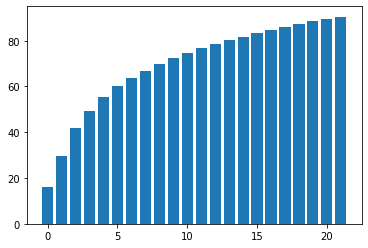

In [37]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance. From 7129 features to ", k, sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

[]

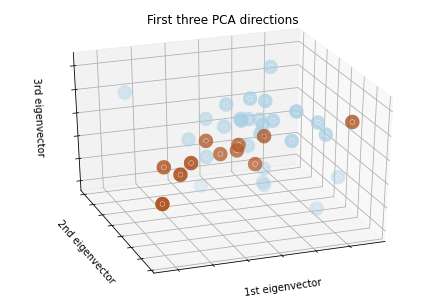

In [38]:
pca3 = PCA(n_components=3).fit(X_train)
X_train_reduced = pca3.transform(X_train)

plt.clf()
fig = plt.figure(1, figsize=(10,6 ))
ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], X_train_reduced[:, 2], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

Text(0.5, 1.0, '2D Transformation of the Above Graph ')

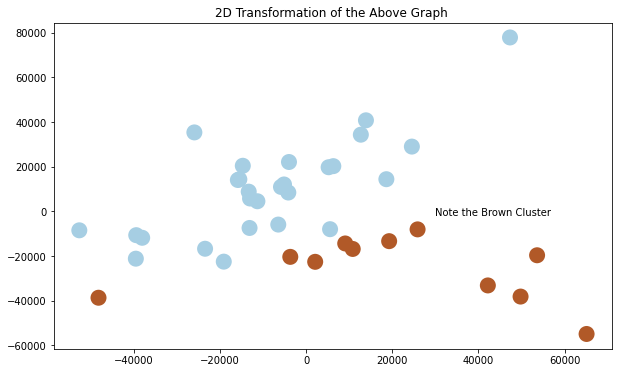

In [39]:
fig = plt.figure(1, figsize = (10, 6))
plt.scatter(X_train_reduced[:, 0],  X_train_reduced[:, 1], c = y_train.iloc[:,1], cmap = plt.cm.Paired, linewidths=10)
plt.annotate('Note the Brown Cluster', xy = (30000,-2000))
plt.title("2D Transformation of the Above Graph ")

In [40]:
# Create model architecture
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(7129,)))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                114080    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 114,097
Trainable params: 114,097
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Create training/validation sets
partial_X_train = X_train_scl[:30]
X_val = X_train_scl[30:]

y_train_label = y_train.iloc[:,1]
partial_y_train = y_train_label[:30]
y_val = y_train_label[30:]

In [42]:
# Set up early stopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

# Fit model
history = model.fit(partial_X_train,
            partial_y_train,
            epochs=50,
            batch_size=4,
            validation_data=(X_val, y_val),
            callbacks=[es])

Epoch 1/50
8/8 [==============================] - 14s 84ms/step - loss: 0.6011 - accuracy: 0.6552 - val_loss: 0.1034 - val_accuracy: 0.8750
Epoch 2/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0259 - accuracy: 1.0000 - val_loss: 0.0382 - val_accuracy: 1.0000
Epoch 3/50
8/8 [==============================] - 0s 4ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 4/50
8/8 [==============================] - 0s 4ms/step - loss: 2.9234e-04 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 1.0000
Epoch 5/50
8/8 [==============================] - 0s 5ms/step - loss: 2.4024e-04 - accuracy: 1.0000 - val_loss: 0.0272 - val_accuracy: 1.0000
Epoch 6/50
8/8 [==============================] - 0s 4ms/step - loss: 1.3278e-04 - accuracy: 1.0000 - val_loss: 0.0268 - val_accuracy: 1.0000
Epoch 7/50
8/8 [==============================] - 0s 5ms/step - loss: 1.0008e-04 - accuracy: 1.0000 - val_loss: 0.0267 - val_accuracy: 1.0000
Epoch 8/50
8/8 [

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Neural Network accuracy:  0.82353


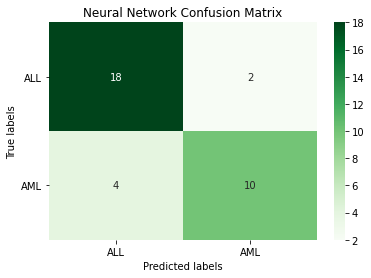

In [45]:
# Make predictions
nn_pred = model.predict_classes(X_test_scl)

print('Neural Network accuracy: ', round(accuracy_score(y_test.iloc[:,1], nn_pred), 5))

cm_nn = confusion_matrix(y_test.iloc[:,1], nn_pred)

ax = plt.subplot()
sns.heatmap(cm_nn, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Neural Network Confusion Matrix') 
ax.xaxis.set_ticklabels(labels) 
ax.yaxis.set_ticklabels(labels, rotation=360);